- 这个模型用所有特征进行训练，训练结果可以，预测结果较为准确。

In [1]:
%matplotlib inline
import torch
from torch.utils import data
from torch import nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# 0. 判断GPU是否可用

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# 1. 数据预处理

In [3]:
data_path = './BostonHousingData.xlsx'
df = pd.read_excel(data_path)

print("数据维度:", df.shape)
print(df.head())

数据维度: (506, 14)
      CRIM    ZN  INDUS  CHAS    NOX     RM   AGE     DIS  RAD  TAX  PTRATIO  \
0  0.00632  18.0   2.31     0  0.538  6.575  65.2  4.0900    1  296     15.3   
1  0.02731   0.0   7.07     0  0.469  6.421  78.9  4.9671    2  242     17.8   
2  0.02729   0.0   7.07     0  0.469  7.185  61.1  4.9671    2  242     17.8   
3  0.03237   0.0   2.18     0  0.458  6.998  45.8  6.0622    3  222     18.7   
4  0.06905   0.0   2.18     0  0.458  7.147  54.2  6.0622    3  222     18.7   

        B  LSTAT  MEDV  
0  396.90   4.98  24.0  
1  396.90   9.14  21.6  
2  392.83   4.03  34.7  
3  394.63   2.94  33.4  
4  396.90   5.33  36.2  


In [4]:
x_data = df.iloc[:, :13].values
y_data = df.MEDV.values
print(x_data.shape)
print(y_data.shape)

(506, 13)
(506,)


In [5]:
# 数据标准化
scaler = StandardScaler()
scaler.fit(x_data)
x_data = scaler.transform(x_data)
x_data


array([[-0.41978194,  0.28482986, -1.2879095 , ..., -1.45900038,
         0.44105193, -1.0755623 ],
       [-0.41733926, -0.48772236, -0.59338101, ..., -0.30309415,
         0.44105193, -0.49243937],
       [-0.41734159, -0.48772236, -0.59338101, ..., -0.30309415,
         0.39642699, -1.2087274 ],
       ...,
       [-0.41344658, -0.48772236,  0.11573841, ...,  1.17646583,
         0.44105193, -0.98304761],
       [-0.40776407, -0.48772236,  0.11573841, ...,  1.17646583,
         0.4032249 , -0.86530163],
       [-0.41500016, -0.48772236,  0.11573841, ...,  1.17646583,
         0.44105193, -0.66905833]])

In [6]:
# 数据集划分
X_train, X_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.1, random_state=50)

In [7]:
X_train.shape

(455, 13)

In [8]:
# 转换为张量
X_train_tensor = torch.from_numpy(X_train.astype(np.float32))
y_train_tensor = torch.from_numpy(y_train.astype(np.float32))
X_test_tensor  = torch.from_numpy(X_test.astype(np.float32))
y_test_tensor  = torch.from_numpy(y_test.astype(np.float32))

In [9]:
y_train_tensor.shape

torch.Size([455])

In [10]:
# 构造数据集与 DataLoader
train_dataset = data.TensorDataset(X_train_tensor, y_train_tensor)
# test_dataset = data.TensorDataset(X_test_tensor, y_test_tensor)

batch_size = 32
train_loader = data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
# test_loader = data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# 2. 网络模型搭建

In [11]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Linear(in_features=13, out_features=64),
            nn.ReLU(),
            nn.Linear(in_features=64, out_features=32),
            nn.ReLU(),
            nn.Linear(in_features=32, out_features=16),
            nn.ReLU(),
            nn.Linear(in_features=16, out_features=1)
        )
    
    def forward(self, X):
        return self.fc(X)
    


In [12]:

model = Model().to(device) 
model

Model(
  (fc): Sequential(
    (0): Linear(in_features=13, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=16, bias=True)
    (5): ReLU()
    (6): Linear(in_features=16, out_features=1, bias=True)
  )
)

# 3. 训练

In [ ]:
def train():
    loss_fun = nn.MSELoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=1e-4)
    num_epochs = 100
    model.train()
    epoch_losses = []  

    for epoch in range(num_epochs): 
        for step, (X, y) in enumerate(train_dataset):
            X = X.to(device)
            y = y.to(device)
            out = model(X)
            loss = loss_fun(out.to(device), y)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        epoch_losses.append(loss.item())
        if epoch % 20 == 0:
            print(f'epoch: {epoch}, loss: {loss.item()}')

    torch.save(model, "./BostonHousingTest3.model")
    return epoch_losses

In [14]:
# train()
loss_history = train()

e:\APP\TechSoftware\Anaconda\anaconda3\envs\neural-network\lib\site-packages\torch\nn\modules\loss.py:610: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


epoch: 0, loss: 0.6503491401672363
epoch: 20, loss: 0.013397031463682652
epoch: 40, loss: 0.0014176024124026299
epoch: 60, loss: 0.004161584656685591
epoch: 80, loss: 0.0015703050885349512


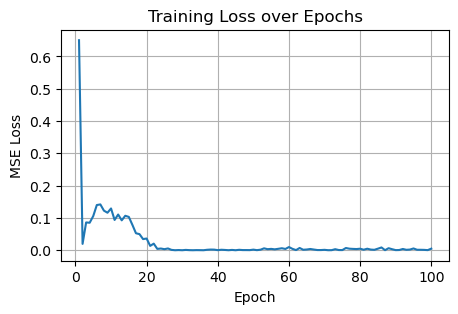

In [ ]:
# 损失函数可视化
plt.figure(figsize=(5, 3))
plt.plot(range(1, len(loss_history) + 1), loss_history, linestyle='-')
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title("Training Loss over Epochs")
plt.grid(True)
plt.show()

# 4. 测试

In [16]:
@torch.no_grad()
def test(X_test_tensor):
    model = torch.load("./BostonHousingTest3.model", weights_only=False).to(device)
    model.eval()
    X_test_tensor = X_test_tensor.to(device)
    out = model(X_test_tensor)
    return out

In [17]:
predictions = test(X_test_tensor)

In [18]:
predictions[10], y_test_tensor[10]

(tensor([13.1588], device='cuda:0'), tensor(14.5000))

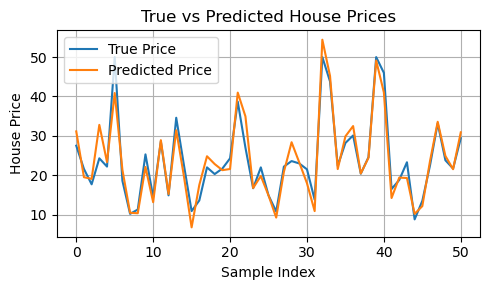

In [ ]:
# 预测结果可视化
predictions_np = predictions.cpu().numpy().flatten()
y_test_np = y_test_tensor.numpy().flatten()

plt.figure(figsize=(5, 3))
plt.plot(y_test_np, label='True Price')
plt.plot(predictions_np, label='Predicted Price')
plt.title("True vs Predicted House Prices")
plt.xlabel("Sample Index")
plt.ylabel("House Price")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [20]:
from sklearn.metrics import mean_squared_error

# 预测值和真实值（注意 flatten 以确保形状一致）
predictions_np = predictions.cpu().numpy().flatten()
y_test_np = y_test_tensor.numpy().flatten()

# 计算均方误差
mse = mean_squared_error(y_test_np, predictions_np)
print(f"Mean Squared Error (MSE): {mse:.4f}")


Mean Squared Error (MSE): 9.3566


- 在选择所有特征作为有效特征时，模型训练较好，预测结果较为准确。